In [34]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import math
warnings.filterwarnings("ignore")

In [35]:
import folium
from folium.plugins import FastMarkerCluster
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")


In [36]:
# Read in appropriate data
green = pd.read_pickle("../preprocessed_data/green.pkl")
cli = pd.read_pickle("../preprocessed_data/climate.pkl").reset_index()

In [37]:
# log transformation for tip excluded amount
green["logged_tip_excluded"] = np.log(green["tip_excluded"])

In [38]:
# log transformation for trip distance
green["logged_trip_distance"] = np.log(green["Trip_distance"])

In [39]:
# mean of each day
each_date = green.groupby("DATE").mean()


In [40]:
# add day of week
each_date["day_of_week"] = pd.to_datetime(cli["DATE"]).dt.day_name().values


In [41]:
# add temperature
each_date["TAVG"] = cli["TAVG"].values

In [42]:
# add number of taxi rides for each day
each_date["count"] = green["DATE"].value_counts().sort_index()

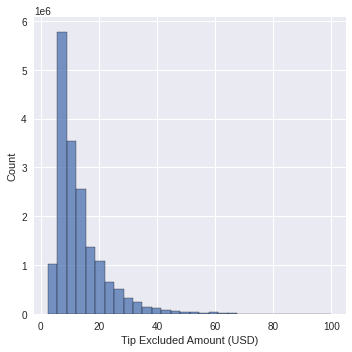

In [43]:
# Plotting
sns.displot(green["tip_excluded"], bins = 30)
plt.xlabel("Tip Excluded Amount (USD)")
plt.savefig("../plots/tipex_prob.pdf")

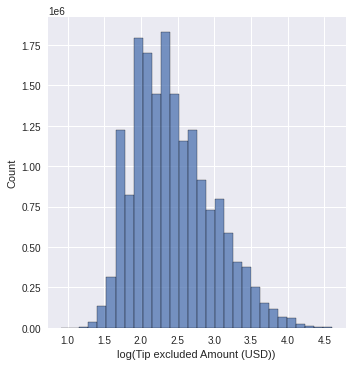

In [44]:
temp = green["tip_excluded"].values

sns.displot(np.log(temp), bins = 30)
plt.xlabel("log(Tip excluded Amount (USD))")
plt.savefig("../plots/tipex_log_prob.pdf")

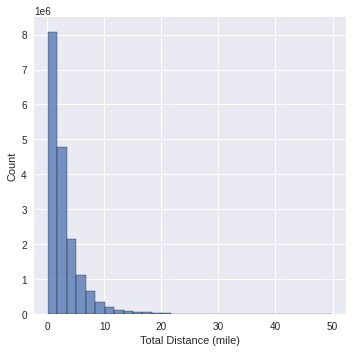

In [45]:
sns.displot(green.loc[green["Trip_distance"] < 50]["Trip_distance"], bins = 30)
plt.xlabel("Total Distance (mile)")
plt.savefig("../plots/trip_distance_dist.pdf")


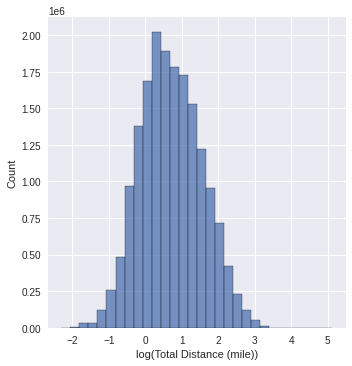

In [46]:
temp = green["Trip_distance"].values
sns.displot(np.log(temp), bins = 30)
plt.xlabel("log(Total Distance (mile))")
plt.savefig("../plots/trip_distance_log_prob.pdf")


<AxesSubplot:>

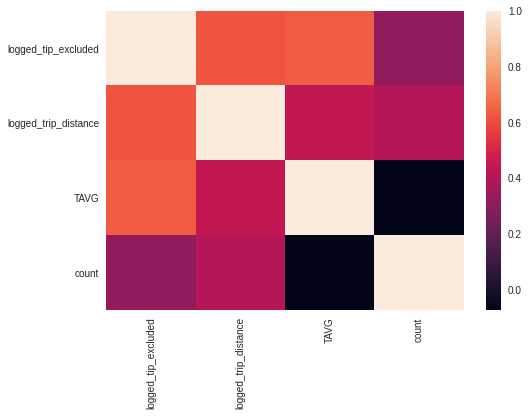

In [47]:
sns.heatmap(each_date[["logged_tip_excluded", "logged_trip_distance", "TAVG", "count"]].corr())

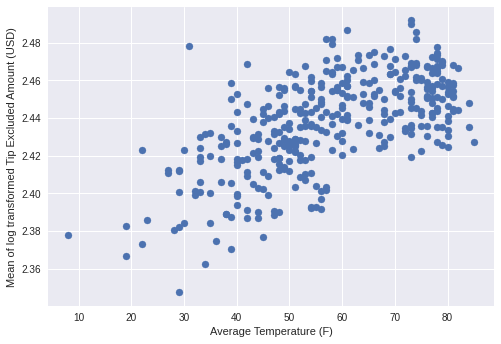

In [48]:
plt.scatter(cli["TAVG"], each_date["logged_tip_excluded"])
plt.xlabel("Average Temperature (F)")
plt.ylabel("Mean of log transformed Tip Excluded Amount (USD)")
plt.savefig("../plots/tavg_vs_log_tip_excluded.pdf")



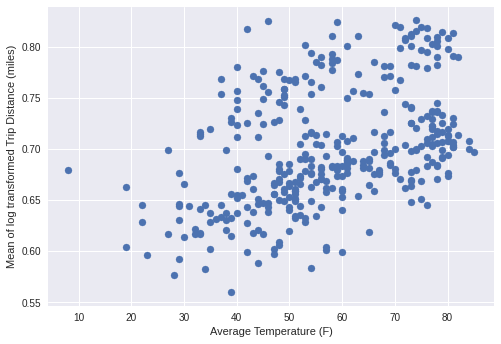

In [49]:
plt.scatter(cli["TAVG"], each_date["logged_trip_distance"])
plt.xlabel("Average Temperature (F)")
plt.ylabel("Mean of log transformed Trip Distance (miles)")
plt.savefig("../plots/tavg_vs_log_trip_distance.pdf")



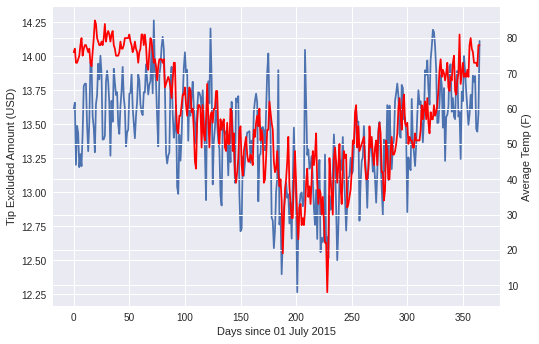

In [50]:
fig,ax = plt.subplots()
ax.plot(range(0,366), green.groupby("DATE").mean()["tip_excluded"].values)
ax.set_ylabel("Tip Excluded Amount (USD)")
ax.set_xlabel("Days since 01 July 2015")

ax2=ax.twinx()
ax2.plot(range(0,366), cli["TAVG"].values, color = "red")
ax2.set_ylabel("Average Temp (F)")

plt.savefig("../plots/temp_tip_same_axis.pdf")



In [51]:
# Top 5 highest Tip excluded printing latex input
print(each_date.nlargest(5, "tip_excluded")[["TAVG", "tip_excluded"]].to_latex())



\begin{tabular}{lrr}
\toprule
{} &  TAVG &  tip\_excluded \\
DATE       &       &               \\
\midrule
2015-09-11 &  73.0 &     14.264316 \\
2015-11-01 &  58.0 &     14.204783 \\
2016-05-19 &  57.0 &     14.195532 \\
2016-05-20 &  61.0 &     14.179235 \\
2015-09-19 &  73.0 &     14.143524 \\
\bottomrule
\end{tabular}



In [52]:
print(each_date.nsmallest(5, "tip_excluded")[["TAVG", "tip_excluded"]].to_latex())


\begin{tabular}{lrr}
\toprule
{} &  TAVG &  tip\_excluded \\
DATE       &       &               \\
\midrule
2016-01-18 &  29.0 &     12.265810 \\
2016-01-04 &  34.0 &     12.398469 \\
2016-02-23 &  39.0 &     12.501256 \\
2016-02-15 &  19.0 &     12.517364 \\
2016-02-08 &  36.0 &     12.560565 \\
\bottomrule
\end{tabular}



In [53]:
each_date["did_rain_or_snow"] = (cli["PRCP"].values > 0) | (cli["SNOW"].values > 0)


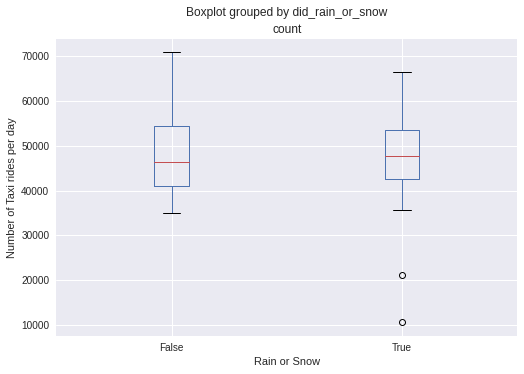

In [54]:
each_date.boxplot("count", by = "did_rain_or_snow")
plt.xlabel("Rain or Snow")
plt.ylabel("Number of Taxi rides per day")
plt.savefig("../plots/rain_or_snow_vs_count.pdf")

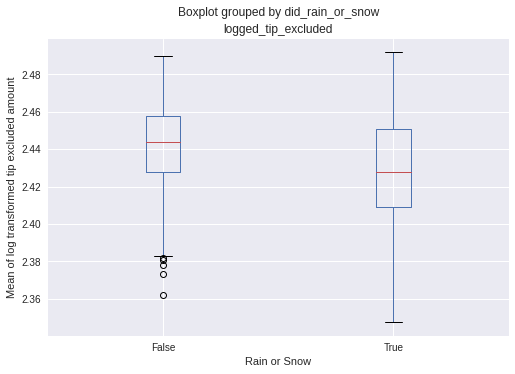

In [55]:
each_date.boxplot("logged_tip_excluded", by = "did_rain_or_snow")
plt.xlabel("Rain or Snow")
plt.ylabel("Mean of log transformed tip excluded amount")
plt.savefig("../plots/rain_or_snow_vs_count.pdf")

In [56]:
# MAPPING 
from folium.plugins import HeatMap


In [57]:
coords = ["Pickup_latitude", "Pickup_longitude"]

In [58]:
green["day_of_week"] = pd.to_datetime(green["DATE"]).dt.day_name().values


In [ ]:
# limit data size to avoid crashes 
limited = green.loc[green["DATE"] < "2015-10-01"]

In [ ]:
# map heat maps for saturday and monday
temp = limited.loc[limited["day_of_week"] == "Saturday"]
pickups_heatmap = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)
pickups_heatmap.add_child(HeatMap(temp[coords].values, radius=12))
pickups_heatmap


In [ ]:
temp = limited.loc[limited["day_of_week"] == "Monday"]
pickups_heatmap = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)
pickups_heatmap.add_child(HeatMap(temp[coords].values, radius=12))
pickups_heatmap


In [ ]:
# map hexbins
fig, axs = plt.subplots(2,2, figsize = (30,30))

limited = green

# Contrast busiest 2 weekdays with least busiest
temp = limited.loc[limited["day_of_week"] == "Saturday"]
axs[0,0].hexbin(x = temp[coords[1]], bins = "log", y= temp[coords[0]], gridsize=100, cmap='inferno')
axs[0,0].set_xlabel("Saturday")

temp = limited.loc[limited["day_of_week"] == "Friday"]
axs[1,0].hexbin(x = temp[coords[1]], bins = "log", y= temp[coords[0]],
           gridsize=100, cmap='inferno')
axs[1,0].set_xlabel("Friday")


temp = limited.loc[limited["day_of_week"] == "Monday"]
axs[0,1].hexbin(x = temp[coords[1]], bins = "log", y= temp[coords[0]],
           gridsize=100, cmap='inferno')
axs[0,1].set_xlabel("Monday")


temp = limited.loc[limited["day_of_week"] == "Tuesday"]
axs[1,1].hexbin(x = temp[coords[1]], bins = "log", y= temp[coords[0]],
           gridsize=100, cmap='inferno')
axs[1,1].set_xlabel("Tuesday")


plt.savefig("../plots/geo_four.pdf")

In [59]:
# write appropriate file for modelling
each_date["SNOW"] = cli["SNOW"].values
each_date["PRCP"] = cli["PRCP"].values

each_date.to_pickle("train_avg.pkl")